In [1]:
!pip install yfinance pandas scikit-learn matplotlib --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [3]:
tickers = [
    "AAPL",  # Apple Inc
    "^GSPC",  # S&P500 Market Index
    "^IRX"  # Short-term Interest Rate Index
]
ticker_hist = yf.download(
                tickers = " ".join(tickers),
                # Download Daily returns for past 5 years
                period = f"{12*5}mo",
                interval = "1d",
                group_by = 'ticker',
                threads = True
            )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [4]:
all(ticker_hist["AAPL"].index == ticker_hist["^GSPC"].index)  # Ensure both indices match

True

In [5]:
def calculate_daily_returns(closing_prices: pd.Series) -> pd.Series:
    closing_prices = closing_prices.dropna()  # Crude data cleanup
    daily_returns = closing_prices.pct_change().iloc[1:]
    return daily_returns
    

In [6]:
aapl_returns = calculate_daily_returns(ticker_hist["AAPL"]["Close"])
sp500_returns = calculate_daily_returns(ticker_hist["^GSPC"]["Close"])

# ^IRX is quoted as an annualized APR, daily conversion just divides by 365
irx_returns = ticker_hist["^IRX"]["Close"] / (365 * 100)
irx_returns = irx_returns[irx_returns.index.isin(aapl_returns.index)]  # Align indices

In [7]:
aapl_cumulative_returns = (1 + aapl_returns).cumprod()
sp500_cumulative_returns = (1 + sp500_returns).cumprod()
irx_cumulative_returns = (1 + irx_returns).cumprod()

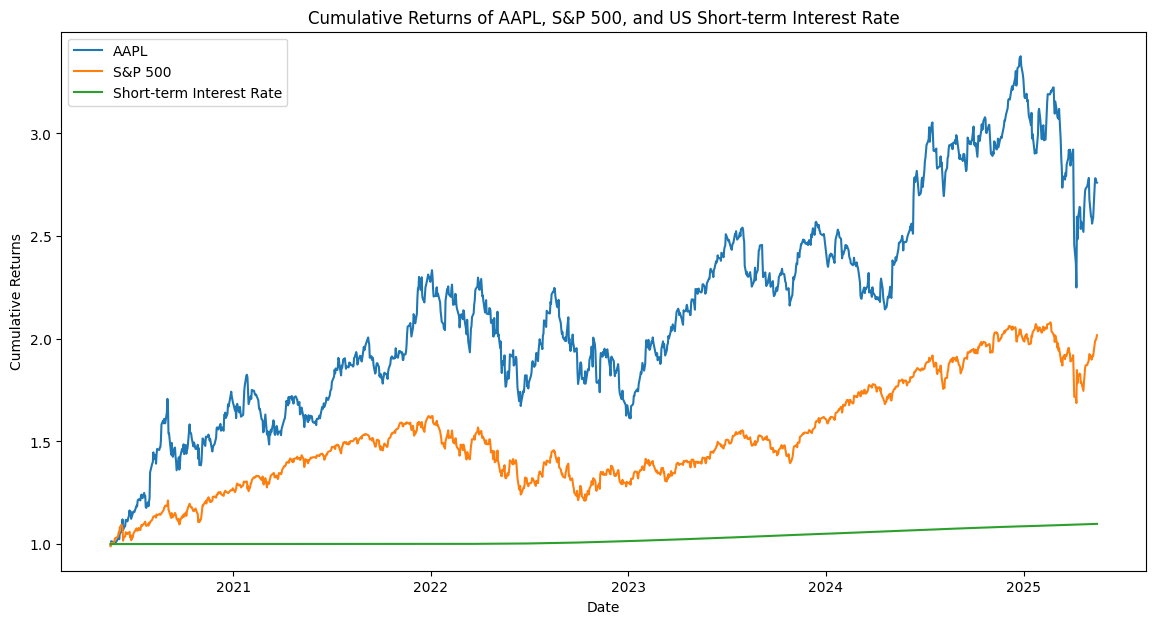

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(aapl_cumulative_returns.index, aapl_cumulative_returns, label="AAPL")
plt.plot(sp500_cumulative_returns.index, sp500_cumulative_returns, label="S&P 500")
plt.plot(irx_cumulative_returns.index, irx_cumulative_returns, label="Short-term Interest Rate")
plt.legend(loc='best')
plt.title("Cumulative Returns of AAPL, S&P 500, and US Short-term Interest Rate")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.show()

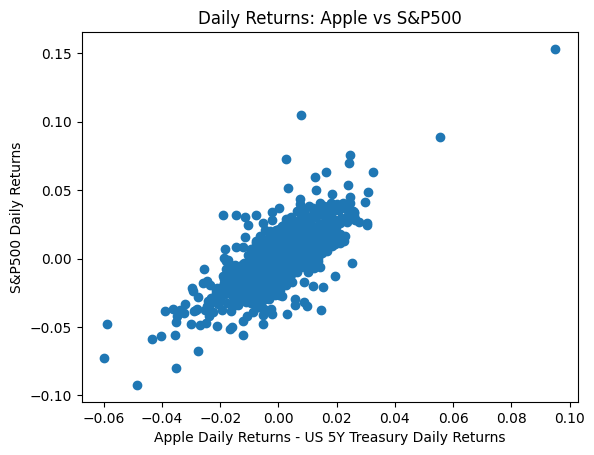

In [9]:
fig = plt.scatter(
    x = sp500_returns - irx_returns,
    y = aapl_returns
)
plt.title('Daily Returns: Apple vs S&P500')
plt.xlabel('Apple Daily Returns - US 5Y Treasury Daily Returns')
plt.ylabel('S&P500 Daily Returns')
plt.show()

CAPM dictates that the expected return of a security follows the equation:

\[ E(R_i) = R_f + \beta_i (E(R_m) - R_f) \]

In [11]:
# Draw a line of best fit across this data
x = sp500_returns - irx_returns
y = aapl_returns
model = LinearRegression()

# Technically the sklearn model gives us the ability to use an arbitrary
# number of features in each index, but in this case we only have one (2-D Regression)
# In CFM 301 you will learn how to use multiple features in a regression model
x = [[ret] for ret in x]

res = model.fit(x, y)
aapl_beta, rf = res.coef_[0], res.intercept_
aapl_beta, rf

(1.2704501217099415, 0.00029155683202707885)

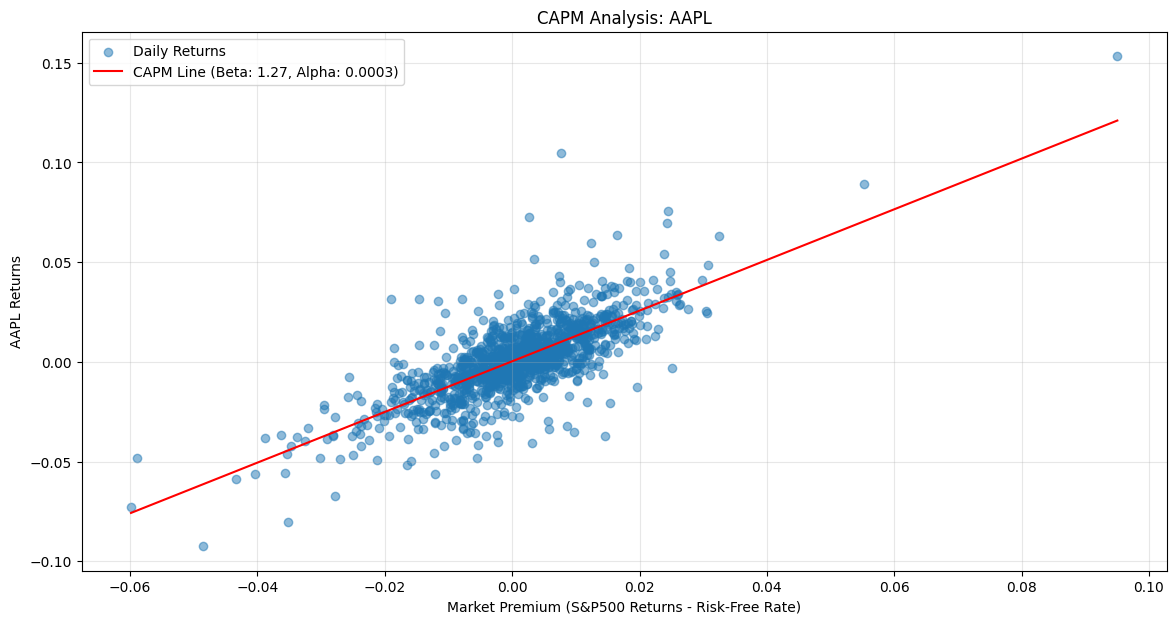

In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(x=sp500_returns - irx_returns, y=aapl_returns, alpha=0.5, label='Daily Returns')

# Line of best fit
x_range = np.linspace(min(sp500_returns - irx_returns), max(sp500_returns - irx_returns), 100)
y_pred = [aapl_beta * xi + rf for xi in x_range]

# Plot the line of best fit
plt.plot(x_range, y_pred, color='red', label=f'CAPM Line (Beta: {aapl_beta:.2f}, Alpha: {rf:.4f})')

plt.title('CAPM Analysis: AAPL')
plt.xlabel('Market Premium (S&P500 Return - Risk-Free Rate)')
plt.ylabel('AAPL Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()